### Import Library

In [119]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import optimizers, regularizers
import matplotlib.pyplot as plt
import random
import os
from tensorflow.keras import layers

### Data preprocessing

In [120]:
base_dir = os.path.join("D:/Datasets/Percobaan/")

# Train set
train_dir = os.path.join(base_dir + "Train")
print("Train class names : ", os.listdir(train_dir))

# Test set
validation_dir = os.path.join(base_dir + "Test")
print("Validation class names : ", os.listdir(validation_dir))

Train class names :  ['padat', 'sedang']
Validation class names :  ['padat', 'sedang']


In [121]:
batch_size = 32
image_size = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=batch_size,
                                                            image_size=image_size)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=batch_size,
                                                                 image_size=image_size)

Found 574 files belonging to 2 classes.
Found 92 files belonging to 2 classes.


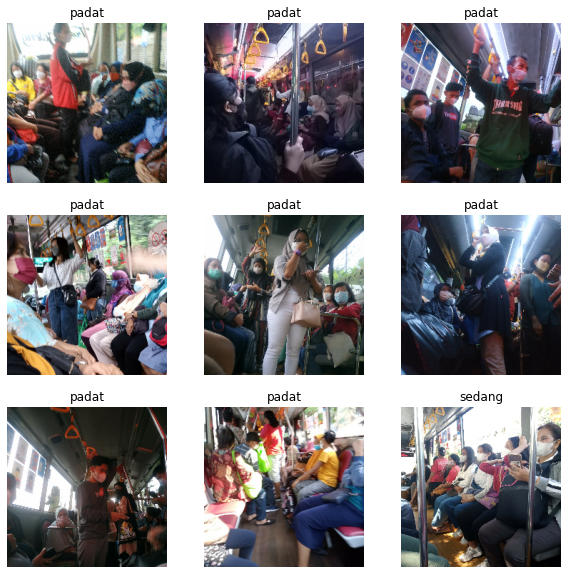

In [122]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Configure the dataset for performance

In [123]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

### Data Augmentation

In [124]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation(0.2),
])

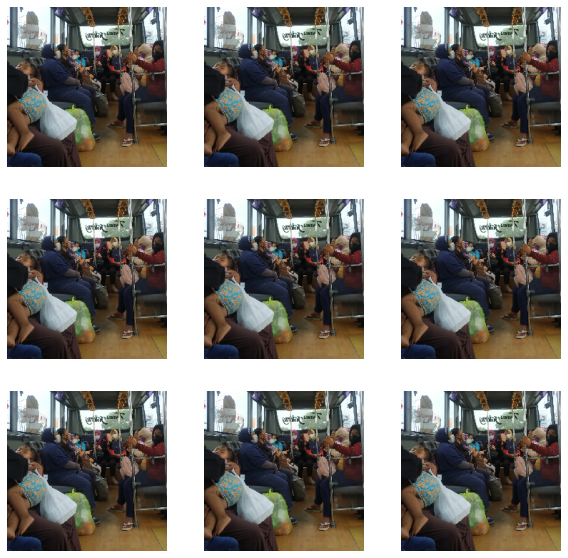

In [125]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

### Base Model

In [126]:
base_model = tf.keras.applications.VGG19(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

In [127]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


### Feature Extraction

In [128]:
base_model.trainable = False
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [129]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [130]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_7   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_7 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg19 (Functional)          (None, 1000)              143667240 
                                                                 
 dropout_5 (Dropout)         (None, 1000)              0   

In [131]:
len(model.trainable_variables)

2

In [149]:
epochs = 10

loss, accuracy = model.evaluate(validation_dataset)

3/3 [==============================] - 47s 16s/step - loss: 1.0710 - accuracy: 0.6848


In [150]:
print("loss: {:.2f}".format(loss))
print("accuracy: {:.2f}".format(accuracy))

loss: 1.07
accuracy: 0.68


In [151]:
history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=validation_dataset)

Epoch 1/10
18/18 [==============================] - 313s 17s/step - loss: 1.0661 - accuracy: 0.6672 - val_loss: 1.0708 - val_accuracy: 0.6848
Epoch 2/10
18/18 [==============================] - 307s 17s/step - loss: 1.0653 - accuracy: 0.6847 - val_loss: 1.0707 - val_accuracy: 0.6848
Epoch 3/10
18/18 [==============================] - 340s 19s/step - loss: 1.0645 - accuracy: 0.7003 - val_loss: 1.0705 - val_accuracy: 0.6848
Epoch 4/10
18/18 [==============================] - 313s 17s/step - loss: 1.0648 - accuracy: 0.6742 - val_loss: 1.0703 - val_accuracy: 0.6848
Epoch 5/10
18/18 [==============================] - 321s 17s/step - loss: 1.0636 - accuracy: 0.7108 - val_loss: 1.0701 - val_accuracy: 0.6848
Epoch 6/10
18/18 [==============================] - 312s 17s/step - loss: 1.0650 - accuracy: 0.6986 - val_loss: 1.0699 - val_accuracy: 0.6848
Epoch 7/10
18/18 [==============================] - 329s 18s/step - loss: 1.0629 - accuracy: 0.6794 - val_loss: 1.0697 - val_accuracy: 0.6848
Epoch 

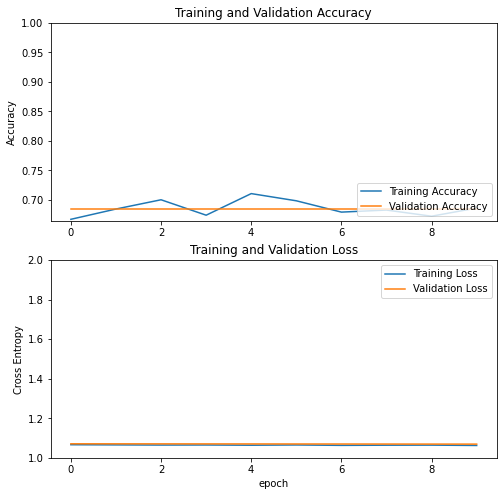

In [152]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([1,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Fine Tunning

In [153]:
base_model.trainable = True

In [154]:
# how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 200

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  26


In [155]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_7   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_7 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg19 (Functional)          (None, 1000)              143667240 
                                                                 
 dropout_5 (Dropout)         (None, 1000)              0   

In [156]:
len(model.trainable_variables)

2

In [157]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
18/18 [==============================] - 323s 17s/step - loss: 1.0630 - accuracy: 0.6864 - val_loss: 1.0689 - val_accuracy: 0.6848
Epoch 11/20
18/18 [==============================] - 322s 18s/step - loss: 1.0630 - accuracy: 0.6829 - val_loss: 1.0687 - val_accuracy: 0.6848
Epoch 12/20
18/18 [==============================] - 315s 17s/step - loss: 1.0623 - accuracy: 0.6916 - val_loss: 1.0685 - val_accuracy: 0.6848
Epoch 13/20
18/18 [==============================] - 320s 17s/step - loss: 1.0625 - accuracy: 0.6864 - val_loss: 1.0684 - val_accuracy: 0.6848
Epoch 14/20
18/18 [==============================] - 319s 17s/step - loss: 1.0626 - accuracy: 0.6864 - val_loss: 1.0682 - val_accuracy: 0.6848
Epoch 15/20
18/18 [==============================] - 316s 17s/step - loss: 1.0615 - accuracy: 0.7073 - val_loss: 1.0680 - val_accuracy: 0.6848
Epoch 16/20
18/18 [==============================] - 318s 17s/step - loss: 1.0621 - accuracy: 0.6760 - val_loss: 1.0678 - val_accuracy: 0.6848

In [158]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

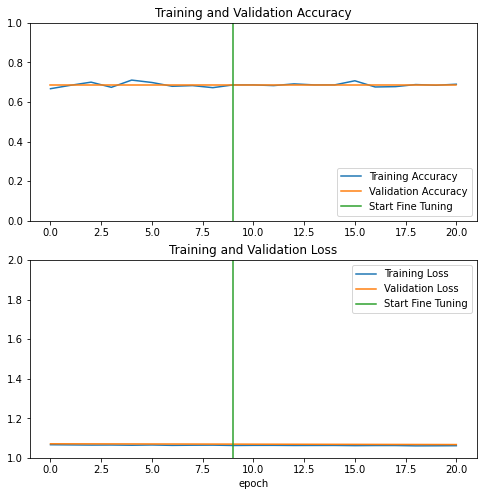

In [159]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([1, 2.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [160]:
loss, accuracy = model.evaluate(validation_dataset)
print('Test accuracy :', accuracy)

3/3 [==============================] - 40s 13s/step - loss: 1.0671 - accuracy: 0.6848
Test accuracy : 0.6847826242446899


Predictions:
 [1 1 0 1 1 0 0 1 1 1 1 0 0 1 0 1 1 0 0 1 0 0 1 0 0 1 0 1 1 0 0 1 0 0 1 0 0
 1 0 0 1 0 1 1 0 1 1 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 0 0 1 0 1 1 0 0 1 0 0 1
 0 0 1 0 0 1 0 1 1 0 1 1 0 1 1 0 0 1 0 0 1 0]
Labels:
 [1 1 1 1 1 0 0 1 1 0 1 1 0 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 0 1 1]


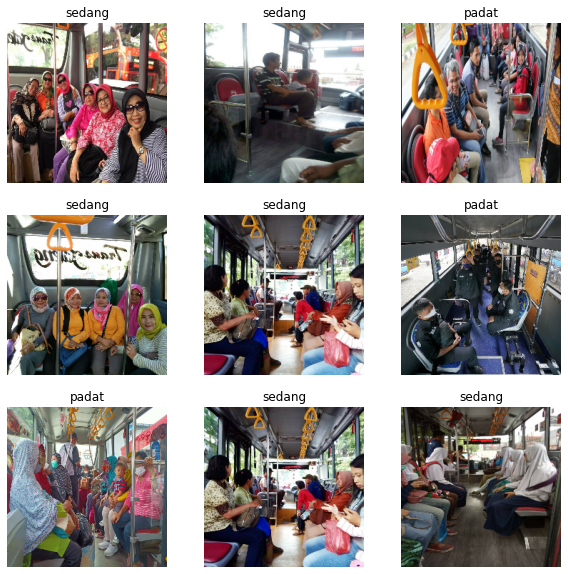

In [163]:
image_batch, label_batch = validation_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")

### Save the model and convert to Tflite

In [165]:
import pathlib

root = tf.train.Checkpoint()
root.v1 = tf.Variable(3.)
root.v2 = tf.Variable(2.)
root.f = tf.function(lambda x: root.v1 * root.v2 * x)

# Save the model into temp directory
export_dir = "D:/Datasets/model_transferLearning"
input_data = tf.constant(1., shape=[1, 1])
to_save = root.f.get_concrete_function(input_data)
tf.saved_model.save(root, export_dir, to_save)

# Convert the model into TF Lite.
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

#save model 
tflite_model_files = pathlib.Path('D:/Datasets/model_transferLearning.tflite')
tflite_model_files.write_bytes(tflite_model)

INFO:tensorflow:Assets written to: D:/Datasets/model_transferLearning\assets


852